# Keras CNN
*July 2018*

*The Center of Applied Data Science*

<a id='Table_of_Content'></a>

* **[1. Google Colaboratory](#1.Google_Colaboratory)**
* **[2. Convolutional Neural Networks with Keras](#2.Convolutional_Neural)**
 * [2.1. Introduction to Keras](#2.1.Introduction)
 * [2.2. Simple ConvNet to train MNIST dataset](#2.2.Simple)
* **[3. Comparing the Sequential and Functional API](#3.Comparing)**
* **[4. A Detour into Images and Keras](#4.A_detour)**
* **[5. Transfer Learning to Classify Images from the Cats and Dogs Dataset](#5.Transfer)**


 



 


<a id='1.Google_Colaboratory'></a>
# 1. Google Colaboratory 

Colaboratory is a Google research project created to help disseminate ML education and research. It's a Jupyter notebook environment that requires no setup to use and runs entirely in the cloud.

Colaboratory notebooks are stored in Google Drive and can be shared just as you would with Google Docs or Sheets. Colaboratory is free to use.

The best thing about Colaboratory is we can enable GPU on it. This makes it easier to develop DL models. It uses the Tesla K80 GPU, which has 4992 cores. To enable GPU, click the **runtime** tab above, click **Change runtime type> Hardware accelerator** and change it from None to **GPU**.




Let's check if GPU is enabled: if GPU is enabled, the output of the cell below should be ```'/device:GPU:0'``` .



In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Click here to go back [Table of Content](#Table_of_Content).

<a id='2.Convolutional_Neural'></a>

# 2. Convolutional Neural Networks with Keras 

In this notebook, we will perform classification tasks on images using convolutional neural networks (ConvNets). First, we will classify digits in the MNIST dataset using a small CNN. Next, we will use transfer learning to classify cats and dogs. 

<a id='2.1.Introduction'></a>

## 2.1. Introduction to Keras 

![Keras](https://upload.wikimedia.org/wikipedia/commons/c/c9/Keras_Logo.jpg =100x)

Here we introduce Keras. Keras is ... 

> a high-level neural networks API, capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

Note that Keras and Tensorflow are already installed on Colaboratory. Should you want to run Keras and Tensorflow on your own system, you would have to have both Keras and Tensorflow installed. Both can be installed via the Conda package manager. 

Below is a condensation of the [30 seconds to Keras](https://keras.io/#getting-started-30-seconds-to-keras) tutorial available in the Keras documentation. 


```
# import modules
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() # use the Sequential model

# adding dense layers
model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dense(units=10, activation='softmax'))

# configure the model's learning process
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# iterate on training data in batches
model.fit(x_train, y_train, epochs=5, batch_size=32)

# Evaluate performance
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)

# Or generate predictions on new data:
classes = model.predict(x_test, batch_size=128)
```


<a id='2.2.Simple'></a>

## 2.2. Simple ConvNet to Train MNIST Dataset

We will train a simple ConvNet on the MNIST dataset for 10 epochs. In each epoch, the model will be trained on all the data in the training set. So 10 epochs means we will iterate the training process 10 times on all our training data.

![MNIST dataset](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png =300x)

First, let's install ```pydot``` and ```graphviz``` to visualize our networks later. This needs to be done early, otherwise we would need to restart our runtime so that Keras can detect these newly-installed packages.


In [17]:
# run this cell then restart runtime then you can continue to run from cell below this
!pip install -q pydot
!apt-get install graphviz -y -qq

Selecting previously unselected package fontconfig.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5ubuntu0.1_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpa

Now let's import the necessary packages.

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


### Assigning (some) hyperparameters 

We will do mini-batch training. Mini-batch means that we will separate our training data into batches. Optimization or backpropagation will be done after finishing one batch of forward propagation. We can specify the amount of data within each batch (```batch size```). Here we will use batch size of 128. We have 10 classes: digits 0 to 9.

In [0]:
batch_size = 128
num_classes = 10
epochs = 10

### Load the dataset 

Let's load the MNIST dataset using the ```keras.datasets``` class and check the dimension of our data.

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)


For training, we have 60,000 images with size of 28x28 each. For validation/test, we have 10,000 images. Now let's add channel dimension here. We have only 1 channel, as our images are grayscale images. However we have to figure out whether the channel dimension is in the 'front' or 'back' of our dataset's dimensions.

if `data_format` is `channels_first`, dimensions of data are`(samples, channels, height, width)`;

if `data_format` is `channels_last`, dimensions of data are `(samples, height, width, channels)`

In [6]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(x_train.shape)
print(x_test.shape)
print(input_shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(28, 28, 1)


It turns out that MNIST has channel dimension as the last dimension of each image, i.e. it is ```channels_last```

In [7]:
K.image_data_format()

'channels_last'

We set our data types for training and validation sets to be `float32` so they are consistent. Then, we normalize our data by dividing it by 255 so now our data is in range of 0 to 1. Why 255? Because each value of pixel range from 0-255.

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [9]:
# to make sure our data is in range from 0 to 1.
print('max value: {}'.format(x_train.max()))
print('min_value: {}'.format(x_train.min()))

max value: 1.0
min_value: 0.0


### Categorical matrices 

Now, let's convert our target class vectors into categorical matrices. This is akin to performing one-hot encoding on the target vector. 

In [10]:
y_train # check y_train values

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [11]:
# convert class vectors to categorical class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)

(60000, 10)


The first image's label (5) has been converted to an array of length 10 with value 1 in index 5 and zeros in all other elements.

In [14]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

and similarly for the second image's label, 0: 

In [15]:
y_train[1] # and for the second image of y_train, corresponds to digit 0 

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Building the model 

Now let's build a simple ConvNet model to train our data. Note that this way of building Keras models is known as the Sequential API. As it does not allow us to create models that share layers or have multiple inputs or outputs [(source)](https://jovianlin.io/keras-models-sequential-vs-functional/), we will have a look at the Functional API later. 

In [0]:
model = Sequential() # create sequential which can consist of stack of layers.

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) # first CONV layer with filter size=3, strides=1, 32 filters.
                                           ## as this this is our first layer, we need to specify our input shape.

model.add(Conv2D(64, (3, 3), activation='relu')) # second CONV layer with filter size=3, strides=1, 64 filters


model.add(MaxPooling2D(pool_size=(2, 2), strides=2)) # Max pooling layer with size=(2,2), strides=2

model.add(Dropout(0.25)) # use Droput. Drop 25% of activations randomly during training.

model.add(Flatten()) # flatten the matrix into a vector so we can have FC layers next.

model.add(Dense(128, activation='relu')) # FC (Fully-connected layer)

model.add(Dropout(0.5)) # Another dropout. Drop 50% of activations randomly during training.

model.add(Dense(num_classes, activation='softmax')) # final prediction softmax layer consist of 10 elements vector
                                                    ## corresponds to our number of target classes.

Let's look at the model summary

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

We have only 2 convolutions layers, one pooling layer, one fully connected layer plus one final softmax layer. Let's visualize our network:

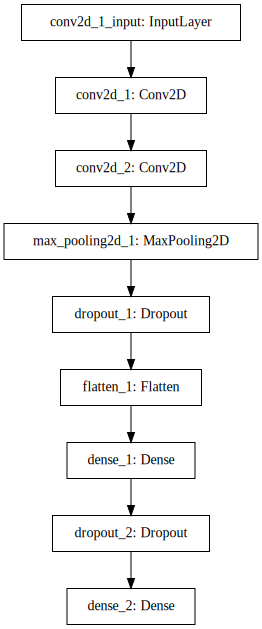

In [14]:
from keras.utils.vis_utils import plot_model
#import pydotplus as pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(model).create(prog='dot', format='svg'))

Let's now set our loss function using a loss function from the ```keras.losses``` package. We will use ```categorical_crossentropy``` as it's suitable for our multinomial classification task. 

Then, we can set the optimization method using a method from the ```keras.optimizers``` package. Here, we will use Adam as our optimization method with ```lr=0.001``` (learning rate). 

We can also specify metrics we want to measure our model performance. We will use accuracy as our metric.

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
metrics=['accuracy'])

### Training the model 

Now, let's train our model.

In [22]:
%%time
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 344us/step - loss: 0.2006 - acc: 0.9384 - val_loss: 0.0444 - val_acc: 0.9867
Epoch 2/10
59264/60000 [============================>.] - ETA: 0s - loss: 0.0717 - acc: 0.978660000/60000 [==============================] - 18s 300us/step - loss: 0.0718 - acc: 0.9786 - val_loss: 0.0347 - val_acc: 0.9883
Epoch 3/10
60000/60000 [==============================] - 18s 301us/step - loss: 0.0518 - acc: 0.9844 - val_loss: 0.0306 - val_acc: 0.9898
Epoch 4/10
33024/60000 [===============>..............] - ETA: 7s - loss: 0.0427 - acc: 0.987160000/60000 [==============================] - 18s 301us/step - loss: 0.0424 - acc: 0.9872 - val_loss: 0.0240 - val_acc: 0.9918
Epoch 5/10
60000/60000 [==============================] - 18s 300us/step - loss: 0.0354 - acc: 0.9891 - val_loss: 0.0258 - val_acc: 0.9917
Epoch 6/10
27264/60000 [============>.................] - ETA: 9s - loss: 0.0298 - acc: 0

As you can see , we managed to achieve 0.99 accuracy with 10 epochs and simple networks in only about 2 minutes. On the other hand, if you train without GPU, training only one epoch can take about 6 minutes. Training with GPU in for this task can speed up the training by about 25x.

<a href="https://ibb.co/nqWB8d"><img src="https://image.ibb.co/dDYf1y/CPU_Training.png" alt="CPU_Training" border="0"></a>
<br>


You can try to modify the models by adding a few more convolution layers, trying  different optimization methods and learning rate or training with more epochs.

Note that our simple ConvNet's performance is already comparable to [state-of-the-art performance using support vector machines (SVM)](https://www2.eecs.berkeley.edu/Pubs/TechRpts/2009/EECS-2009-159.pdf) in combination with gradient histograms for improved features with approximately 125,000 computations (error .79%). While the SVM approach is arguably easier and faster, we did not have to use a particularly complex ConvNet architecture to achieve comparable results. 

Source: *Maji, S & Malik, J 2009, Fast and accurate digit classification. *

See http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html for other state-of-the-art performance on the MNIST.

Click here to go back [Table of Content](#Table_of_Content).

<a id='3.Comparing'></a>
# 3. Comparing the Sequential and Functional API 

It's important to familiarise with the Functional API, as it allows for more flexibility. This allows us to use more complex architectures like ResNet. We implement the code above in the Functional API: 

|Sequential API| Functional API|
|-----|-----|
|`model = Sequential()`|`visible = Input(shape = input_shape)`|
|`model.add(Conv2D(32, `<br>`kernel_size=(3, 3),`<br>` activation='relu',`<br>`input_shape=input_shape))`|`hidden = Conv2D(32, `<br>`kernel_size = (3,3), `<br>`activation = 'relu')(visible)`|
|`model.add(Conv2D(64, `<br>`(3, 3), `<br>`activation='relu'))`|`hidden = Conv2D(64, `<br>`(3,3), `<br>`activation = 'relu')(hidden)`|
|`model.add(MaxPooling2D(pool_size=(2, 2)))`|`hidden = MaxPooling2D(pool_size = (2,2))(hidden)`|
|`model.add(Dropout(0.25))`| `hidden = Dropout(.25)(hidden)`|
|`model.add(Flatten())`|`hidden = Flatten()(hidden)`|
|`model.add(Dense(128, activation='relu'))`| `hidden = Dense(128, activation = 'relu')(hidden)`|
|`model.add(Dropout(0.5))`|`hidden = Dropout(.5)(hidden)`|
|`model.add(Dense(num_classes, activation='softmax'))`|`hidden = Dense(num_classes, activation = 'softmax')`|
||`model = Model(inputs = visible, outputs = hidden)`|

And finally, we compile our model: 

`model.compile(loss=keras.losses.categorical_crossentropy,`<br>`optimizer=keras.optimizers.Adam(lr=0.001),`<br>`metrics=['accuracy'])`

Notes: 
* Instead of differentiating between the visible and hidden layers, it is common to refer to both of them as `x` when using the Functional API. 

Click here to go back [Table of Content](#Table_of_Content).

<a id='4.A_detour'></a>
# 4. A Detour into Images and Keras 

As we will focus on computer vision applications, it is important to understand how to import images in Keras. 
* `ImageDataGenerator()` is used to generate batches of tensor image data and perform data augmentation on these images;
* `flow(x, y)` or `flow_from_directory(directory)` is a method of ImageDataGenerator() that generates batches of augmented data;
* use `fit()` or `fit_generator()` respectively to fit the model;
* use `predict()` or `predict_generator()` respectively to make predictions

![](https://cdn-images-1.medium.com/max/1600/1*IqWwrQJk2-iILjKCAdPQ6w.png =500x)

Recall how we loaded our data while working on the MNIST images. If we wanted to do data augmentationon on the MNIST, we would have used `flow()` in conjunction with `ImageDataGenerator()`. `flow(x, y)` is recommended for smaller datasets, and `flow_from_directory(dir)` is recommended for larger datasets, where not all data can be loaded at once. When using `flow_from_directory()`, classes are inferred from the directory structure, and Keras sorts the directory names before encoding. The mapping can be obtained from the `class_insices` attribute of the model. Some sample output of the `class_indices` attribute is as follows: 
```
{'class_14': 5, 'class_10': 1, 'class_11': 2, 'class_12': 3, 'class_13': 4, 'class_2': 6, 'class_3': 7, 'class_1': 0, 'class_6': 10, 'class_7': 11, 'class_4': 8, 'class_5': 9, 'class_8': 12, 'class_9': 13}
```
If using a data generator created via `flow_from_directory()` from `ImageDataGenerator()`, it is important to use the `class_indices` attribute of the `flow_from_directory()` object to map the inferred classes to the actual class names. Sample code on how to map the classes to class names can be found at the source link. 

[source](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2)

Click here to go back [Table of Content](#Table_of_Content).

<a id='5.Transfer'></a>

# 5. Transfer Learning to Classify Images from the Cats and Dogs Dataset


We would like to use ConvNets to classify pictures which have either cats or dogs. We can use architectures made by machine learning researchers, as they have spent more time and computation to experiment on architectures that work best on different problems. We can use an idea called transfer learning, which, broadly speaking, re-uses pre-trained weights on existing architectures trained on different datasets to our task. 

For this walkthrough, we'll use weights from the [ResNet50](https://keras.io/applications/#resnet50) architecture pre-trained on the [ImageNet](https://www.image-net.org) dataset. ResNet50 can be used in Keras using ```keras.applications``` package. 

 
This requires us to do some Unix file operations to (1) unzip (2) move the unzipped files into the folder structures. Fortunately, these files are available from fast.ai in the appropriate directory structure so that we can use `flow_from_directory()` instead of `flow()` and have Keras take care of the data labelling. 

## Load the data 

Here we are downloading the data from [fast.ai](http://www.fast.ai/)'s repository.

(Documentation for [mkdir](http://man7.org/linux/man-pages/man2/mkdir.2.html) [wget](http://man7.org/linux/man-pages/man1/wget.1.html) [unzip](https://linux.die.net/man/1/unzip))

In [5]:
!mkdir -p data && wget http://files.fast.ai/data/dogscats.zip && unzip -qq -o dogscats.zip -d data/ 

--2018-07-24 03:02:38--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  97.4MB/s    in 8.5s    

2018-07-24 03:02:47 (95.9 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



[ls](https://www.rapidtables.com/code/linux/ls.html)

In [27]:
!ls data/dogscats/train # check the data directory

cats  dogs


Now let's import all necessary packages. We'll also specify the directory of our data, the dimensions which we want to resize our images to, and the [batch size](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network).

In [0]:
import numpy as np

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input

import matplotlib.pyplot as plt
import os

%matplotlib inline

PATH = "data/dogscats/"
sz=224 # resize images to 224*224
batch_size=64 # feed 64 samples to the neural network at a time

# train and validation directory
train_data_dir = f'{PATH}train'
validation_data_dir = f'{PATH}valid'
test_dir = f'{PATH}test1'

Let's take a look at one of the cat images:

In [20]:
#os.listdir() returns a list of filenames - subset the first five of these
files = os.listdir(f'{PATH}valid/dogs')[:5] 
files

['dog.7317.jpg',
 'dog.10505.jpg',
 'dog.855.jpg',
 'dog.11172.jpg',
 'dog.9782.jpg']

In [15]:
# print the second image 
img = plt.imread(f'{PATH}valid/cats/{files[1]}')
plt.imshow(img)

print(img.shape) # print image dimensions shape

## Data Augmentation

Data augmentation can be really effective in image classification to reduce overfitting. The idea here is that it does not matter where the cat or dog is located, but the most important thing for networks to learn is whether it's a dog or cat.

You can perform data augmentation in Keras using the ```ImageDataGenerator``` class.  Here we use 3 type of image augmentation:

1) [shearing](https://en.wikipedia.org/wiki/Shear_mapping)
![](https://upload.wikimedia.org/wikipedia/commons/9/92/VerticalShear_m%3D1.25.svg =70x)
2) random zoom.
3) horizontal flip

In [6]:
# Data augmentation and split
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, # preprocessing for resnet50
                                   shear_range=0.2, # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
                                   zoom_range=0.2, # Range for random zoom.
                                   horizontal_flip=True # Randomly flip inputs horizontally.
                                  )

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(sz, sz),
                                                    batch_size=batch_size, 
                                                    class_mode='binary')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        shuffle=False,
                                                        target_size=(sz, sz),
                                                        batch_size=batch_size, 
                                                        class_mode='binary')


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Compile the model

Recall that we are using [ResNet50](https://keras.io/applications/#resnet50) weights trained on the ImageNet dataset to perform transfer learning. The model is assigned to `base_model`. By specifying `include_top = False`, we will remove only the final fully connected (dense) layers from the architecture. 

Then, we add our own layers. Here, we add a [GlobalAveragePooling](https://keras.io/layers/pooling/#globalaveragepooling2d) layer, a fully connected ([Dense](https://keras.io/layers/core/#dense)) layer, and finally a sigmoid prediction layer as this is a binary classification task. We will freeze all layers except the layers we add. 

The ResNet50 architecture was introduced by Kaiming He et. al. 

*K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition", https://arxiv.org/abs/1512.03385*

In [6]:
ResNet50().summary()

The model is assigned to `base_model`. By specifying `include_top = False`, we will remove only the final fully connected (dense) layers from the architecture. 

Then, we add our own layers. Here, we add a [GlobalAveragePooling](https://keras.io/layers/pooling/#globalaveragepooling2d) layer, a fully connected ([Dense](https://keras.io/layers/core/#dense)) layer, and finally a sigmoid prediction layer as we are dealing with binary classification task. We will not train ('freeze') all layers except the layers we add. 

Notice that we are now using the Functional instead of the Sequential API. 

In [4]:
base_model = ResNet50(weights='imagenet', 
                      include_top=False) # include_top=False to remove last fc layers

x = base_model.output 


x = GlobalAveragePooling2D()(x) # global pooling layer: reduce size into a vector which consist of the average 
                                ## of each channels from previous activations
                                ## help to reduce overfitting by doing dimensionality reduction instead of 
                                ## flattening the previous activations matrix.
  
x = Dense(1024, activation='relu')(x) # FC layer
predictions = Dense(1, activation='sigmoid')(x) # Final sigmoid layer

94658560/94653016 [==============================] - 2s 0us/step


Before we compile our model, we specify which layers to freeze (not trainable), by setting the `trainable` attribute of `base_model` as `False`. Note that we freeze all layers in `base_model`.

Now, we can compile our model. We select the  [```rmsprop```](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) optimisation algorithm with a  ```binary_crossentropy```  loss function as we are dealing with a binary classification problem. The metric used to evaluate our model is ```accuracy```.

In [1]:
# compile model
model = Model(inputs=base_model.input, 
              outputs=predictions)

for layer in base_model.layers: 
  layer.trainable = False # freeze all layers in the base ResNet50 model, i.e. don't train weights
  
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy']) 

NameError: ignored

Use the `summary()` method to print the architecture of our model. 

In [6]:
model.summary()

In [7]:
from keras.utils.vis_utils import plot_model
#import pydotplus as pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training the model 

Time to train the model! 

Since we used an `ImageDataGenerator` via `flow_from_directory` to load our data, we fit our model using the `fit_generator()` method instead of `fit()`. 

* `generator` produces batches of data;
* `steps_per_epoch` specifies the number of batches of samples from `generator` so that the model has seen the entire dataset once (one epoch);
* `epochs` specifies the number of iterations over the entire dataset;
* if `use_multiprocessing` is `True`, Keras will use process-based threading;
* `workers` specifies the maximum number of processes to spin up when using process-based threading;
* `validation_data` generates data to evaluate the model at the end of an epoch; and
* `validation_steps`: if `validation_data` is a generator, it specifies the number of samples to yield from the generator before stopping at the end of the epoch. 

Note that the `.n` attribute to the train and validation generators provides the number of samples in the entire training and validation datasets respectively. 


In [14]:
%%time
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=train_generator.n // batch_size, # train_generator.n is the total data in train set
                    epochs=1, # no. of epochs
                    use_multiprocessing = True, 
                    workers=10, # max number of processes while using multi-thread
                    validation_data=validation_generator, 
                    validation_steps=validation_generator.n // batch_size) # validation_generator.n is the total data in validation set

Epoch 1/1
359/359 [==============================] - 389s 1s/step - loss: 0.0747 - acc: 0.9734 - val_loss: 0.0513 - val_acc: 0.9859
CPU times: user 1min 11s, sys: 23.3 s, total: 1min 34s
Wall time: 6min 29s


## Manually inspecting the data




First, we use the `predict_generator` method on our model to generate predictions on our validation set.

The generator provides batches of 64 samples, with 32 steps (check `len(validation_generator)`) to run through the entire dataset. By default, `steps` is set as `len(validation_generator)`, so that `predict_generator()` predicts for the entire dataset.

In [0]:
preds = model.predict_generator(generator = validation_generator)

Now, set the filenames and actual class labels to `filenames` and `expected_labels` respectively. Note that `expected_labels` is a list of 0s and 1s, and the `class_indices` attribute of the generator is: 



In [95]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

For convenience, to make `preds` a one-dimensional vector, we index `preds` using `[:,0]`. We also round the predictions to the closest integer using [`np.round`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.round_.html), which is equivalent to predicting 1 if the prediction is $\geq.5$, and 0 if the prediction is $<0.5$.

In [0]:
filenames, expected_labels = validation_generator.filenames, validation_generator.classes

our_predictions = preds[:,0]
our_labels = np.round(our_predictions) # .5 as prediction threshold

Let's compute accuracy manually: 

In [17]:
# accuracy 
sum(expected_labels == our_labels)/2000 

0.972

Some helper functions to assist with plotting. Don't worry about the details of these functions for now. 

In [0]:
from keras.preprocessing import image

def plots_idx(idx, titles=None):
  """
  Helper function to plot images given their file name in the validation set. 
  Concatenates file path and filenames. 
  Plots is a helper function 
  
  idx: file name 
  titles: title of subplot
  """
  plots([image.load_img(validation_data_dir + '/' + filenames[i]) for i in idx], titles=titles)
    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
  """
  Helper function to plot a sequence of images by file directory given 
  file directories.
  ims: file directories 
  figsize: size of the figure 
  rows: number of rows 
  titles: title of subplot
  """
  if type(ims[0]) is np.ndarray:
      ims = np.array(ims).astype(np.uint8)
      if (ims.shape[-1] != 3):
          ims = ims.transpose((0,2,3,1))
  f = plt.figure(figsize=figsize)
  for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims)//rows, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i], interpolation=None if interp else 'none')

#Number of images to view for each visualization task
n_view = 4

Let's now inspect the validation set manually. References for some of the functions used: 
1. `np.where(condition)`: Return indices of elements depending on condition. 
2. `np.random.permutation()`: Randomly permute a sequence.
3. `np.argsort()`: Returns the indices that would sort an array. Defaults to ascending. 

### A few correct labels at random


In [28]:
# Indices of True elements are located in index 0
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))

# randomly select n_view elements from correct
idx = np.random.permutation(correct)[:n_view]

# plot
plots_idx(idx, our_predictions[idx])

### A few incorrect labels at random


In [29]:
incorrect = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))

idx = np.random.permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

### Images where our model correctly identified cats

In [30]:
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print("Found %d confident correct cats labels" % len(correct_cats))

# sort indices in ascending order of probabilities, pick n_view to plot
most_correct_cats = np.argsort(our_predictions[correct_cats])[:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

### Images where our model correctly identified dogs


In [31]:
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print("Found %d confident correct dogs labels" % len(correct_dogs))

# sort indices in descending order of probabilities, pick n_view to plot 
most_correct_dogs = np.argsort(-our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

### The images our model was most confident were of dogs, but were actually of cats


In [53]:
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_dogs) is not 0: 
  # sort incorrectly classified dogs by descending probability
  most_incorrect_dogs = np.argsort(-our_predictions[incorrect_dogs])[:n_view]
  plots_idx(incorrect_dogs[most_incorrect_dogs], 
            our_predictions[incorrect_dogs][most_incorrect_dogs])

### The most uncertain labels (i.e. those with probability closest to 0.5).


In [52]:
# sort images by deviation from .5 
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

### Confusion matrix 

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)
cm

Click here to go back [Table of Content](#Table_of_Content).